# Exoplanet from TESS Analysis
#### Author: Xiaorong Yan
#### Date:  2021/12/15
If you ever imagined there is another world out there in space, you probably heard about exoplanets. Exoplanets are planets that are in other solar systems located in our universe. These solar systems can be very different from ours, such as some have binary star (two stars as the center of the solar system), massive Jovian planets orbiting closer to the host star. However, exoplanets are pretty hard to find. If you are interested, learn more about them here https://exoplanets.nasa.gov/. .
The goal of this project is to use skills I learned from data science class to solve a problem I find interesting in, in this case, astronomy related. Since I major in CS and minor in astronomy, this will be my first ever project for me to combine my knowledge in both field. The dataset I will be using is from NASA's exoplanet archive. It documented all the exoplanet candidates from TESS[1] Detail see below. 
Found in https://github.com/awesomedata/awesome-public-datasets.

Exoplanet data available from
https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=TOI
NASA Exoplanet Archive
To use up-to-date data, you can either: 
a) download from the link
b) use NASA's API (refer to https://exoplanetarchive.ipac.caltech.edu/docs/program_interfaces.html)

From NASA Exoplanet Archive's front page, we can see that there are total of 4884 confirmed exoplanets, 175 of which came from TESS, which has 4708 candidates (as of December 16th, 2021). That leave us double check a lot of candidates. If we can use data science to help confirming the potential candidate from TESS, we will definitely speed up the process. From the data science class, I recalled that we used sklearn to train models on dataset to predict results. Further examing the dataset confirmed my idea that using what I have learned to predict condidates is indeed doable. So here we go. 




[1] Transit Surveys. Launched in April 2018, TESS is surveying the sky for two years to find transiting exoplanets around the brightest stars near Earth.


<img src="https://i.cbc.ca/1.6078872.1624558670!/fileImage/httpImage/image.jpeg_gen/derivatives/16x9_940/earth-and-exoplanets.jpeg">

In [1]:
# importing libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import KFold 
from sklearn.metrics import confusion_matrix





#  Data curation, parsing, and management
The downloaded csv files are not well formatted since the top 1*n cells are name description, so pd.read_csv() does not work nicely. So, we are ignoring the first n rows by using "skiprows" parameter in read_csv() function.

In [2]:
df_TOI = pd.read_csv('TOI_202112.csv', skiprows = 69)
df_TOI.head()

,toi,tid,tfopwg_disp,rastr,ra,decstr,dec,st_pmra,st_pmraerr1,st_pmraerr2,...,st_logg,st_loggerr1,st_loggerr2,st_logglim,st_rad,st_raderr1,st_raderr2,st_radlim,toi_created,rowupdate
0,1000.01,50365310,FP,07h29m25.85s,112.357708,-12d41m45.46s,-12.695960,-5.964,0.085,-0.085,...,4.19,0.07,-0.07,0,2.16986,0.072573,-0.072573,0,2019-07-24 15:58:33,2021-10-29 12:59:15
1,1001.01,88863718,PC,08h10m19.31s,122.580465,-05d30m49.87s,-5.513852,-4.956,0.102,-0.102,...,4.03,0.09,-0.09,0,2.01000,0.090000,-0.090000,0,2019-07-24 15:58:33,2021-10-29 12:59:15
2,1002.01,124709665,FP,06h58m54.47s,104.726966,-10d34m49.64s,-10.580455,-1.462,0.206,-0.206,...,NaN,NaN,NaN,0,5.73255,NaN,NaN,0,2019-07-24 15:58:33,2021-10-29 12:59:15
3,1003.01,106997505,FP,07h22m14.39s,110.559945,-25d12m25.26s,-25.207017,-0.939,0.041,-0.041,...,4.15,1.64,-1.64,0,NaN,NaN,NaN,0,2019-07-24 15:58:33,2021-10-29 12:59:15
4,1004.01,238597883,FP,08h08m42.77s,122.178195,-48d48m10.12s,-48.802811,-4.496,0.069,-0.069,...,4.14,0.07,-0.07,0,2.15040,0.060467,-0.060467,0,2019-07-24 15:58:33,2021-10-29 12:59:15


The TOI (TESS Object of Interest) dataframe contains all the candidates collected and validated from TESS. The dataframe contains columns that we do not need for our project. Therefore, we need to tidy up the data and only leave what's useful.

In [3]:
# The first step is to see what columns are in the data frame we need to keep by making their name more descriptive.
print(df_TOI.shape)
df_TOI.columns

(4708, 65)


Index(['toi', 'tid', 'tfopwg_disp', 'rastr', 'ra', 'decstr', 'dec', 'st_pmra',
       'st_pmraerr1', 'st_pmraerr2', 'st_pmralim', 'st_pmdec', 'st_pmdecerr1',
       'st_pmdecerr2', 'st_pmdeclim', 'pl_tranmid', 'pl_tranmiderr1',
       'pl_tranmiderr2', 'pl_tranmidlim', 'pl_orbper', 'pl_orbpererr1',
       'pl_orbpererr2', 'pl_orbperlim', 'pl_trandurh', 'pl_trandurherr1',
       'pl_trandurherr2', 'pl_trandurhlim', 'pl_trandep', 'pl_trandeperr1',
       'pl_trandeperr2', 'pl_trandeplim', 'pl_rade', 'pl_radeerr1',
       'pl_radeerr2', 'pl_radelim', 'pl_insol', 'pl_insolerr1', 'pl_insolerr2',
       'pl_insollim', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2', 'pl_eqtlim',
       'st_tmag', 'st_tmagerr1', 'st_tmagerr2', 'st_tmaglim', 'st_dist',
       'st_disterr1', 'st_disterr2', 'st_distlim', 'st_teff', 'st_tefferr1',
       'st_tefferr2', 'st_tefflim', 'st_logg', 'st_loggerr1', 'st_loggerr2',
       'st_logglim', 'st_rad', 'st_raderr1', 'st_raderr2', 'st_radlim',
       'toi_created', 'rowupda

In [77]:
# column description from the website, https://exoplanetarchive.ipac.caltech.edu/docs/API_TOI_columns.html
# Using the descriptive name to replace the shorter version that is used in the csv file.
dscpt = requests.get('https://exoplanetarchive.ipac.caltech.edu/docs/API_TOI_columns.html').text
soup = BeautifulSoup(dscpt, 'html.parser')
table = soup.find_all("td", {"class": "description"})

for t in table[:5]:
    print(t.text)
# only printing out a few because the whole thing is too long to display

 A number used to identify and track a TESS Object of Interest (TOI). 
        TOIs are identified and numbered by the TESS Project. A TOI name has 
        an integer and a decimal part of the format TOI-NNNNN.DD. The integer 
        part designates the target star; the two-digit decimal part identifies 
        a unique transiting object associated with that star. 
The integer portion of the TOI Identifier, designating the target star. (See toi description above.)

        Target identification number, as listed in the TESS Input Catalog (TIC).
  

    A number used to identify and track a Community-identified TESS Object of Interest (CTOI). A CTOI name has an integer and a decimal part, where the integer is the TESS Input Catalog (TID) referring to the target star, and the two-digit decimal part identifies a unique transiting object associated with that star.

Number of planet candidates in the planetary system.



In [5]:
# Renaming the columns
df_TOI = df_TOI.rename(columns={
    'toi': 'TESS Object of Interest',
    'tid':'TESS Object of Interest Prefix',
    'tfopwg_disp': 'Disposition',
    'rastr':'Right Ascension',
    'ra':'Right Ascension Decimal', 
    'decstr':'Declination',
    'dec':'Declination Decimal',
    'st_pmra': 'PMRA',
    'st_pmraerr1':'PMRA Upper Unc', 
    'st_pmraerr2':'PMRA Lower Unc', 
    'st_pmralim':'PMRA Limit Flag', 
    'st_pmdec':'PMDec', 
    'st_pmdecerr1':'PMDec Upper Unc',
    'st_pmdecerr2':'PMDec Lower Unc', 
    'st_pmdeclim':'PMDec Limit Flag', 
    'pl_tranmid':'Planet Transit Midpoint Value',
    'pl_tranmiderr1':'Planet Transit Midpoint Upper Unc',
    'pl_tranmiderr2':'Planet Transit Midpoint Lower Unc',
    'pl_tranmidlim':'Planet Transit Midpoint Limit Flag',
    'pl_orbper':'Planet Orbital Period Value',
    'pl_orbpererr1':'Planet Orbital Period Upper Unc',
    'pl_orbpererr2':'Planet Orbital Period Lower Unc',
    'pl_orbperlim':'Planet Orbital Period Limit Flag', 
    'pl_trandurh':'Planet Transit Duration Value',
    'pl_trandurherr1':'Planet Transit Duration Upper Unc',
    'pl_trandurherr2':'Planet Transit Duration Lower Unc', 
    'pl_trandurhlim':'Planet Transit Duration Limit Flag',
    'pl_trandep':'Planet Transit Depth Value', 
    'pl_trandeperr1':'Planet Transit Depth Upper Unc',
    'pl_trandeperr2':'Planet Transit Depth Lower Unc',
    'pl_trandeplim':'Planet Transit Depth Limit Flag',
    'pl_rade':'Planet Radius Value',
    'pl_radeerr1':'Planet Radius Value Upper Unc',
    'pl_radeerr2':'Planet Radius Value Lower Unc',
    'pl_radelim':'Planet Radius Limit Flag',
    'pl_insol':'Planet Insolation Value',
    'pl_insolerr1':'Planet Insolation Upper Unc',
    'pl_insolerr2':'Planet Insolation Lower Unc',
    'pl_insollim':'Planet Insolation Limit Flag',
    'pl_eqt':'Planet Equilibrium Temperature Value',
    'pl_eqterr1':'Planet Equilibrium Temperature Upper Unc',
    'pl_eqterr2':'Planet Equilibrium Temperature Lower Unc',
    'pl_eqtlim':'Planet Equilibrium Temperature Limit Flag',
    'st_tmag':'TESS Magnitude',
    'st_tmagerr1':'TESS Magnitude Upper Unc',
    'st_tmagerr2':'TESS Magnitude Lower Unc',
    'st_tmaglim':'TESS Magnitude Limit Flag',
    'st_dist':'Stellar Distance',
    'st_disterr1':'Stellar Distance Upper Unc',
    'st_disterr2':'Stellar Distance Lower Unc',
    'st_distlim':'Stellar Distance Limit Flag',
    'st_teff':'Stellar Effective Temperature Value',
    'st_tefferr1':'Stellar Effective Termperature Upper Unc',
    'st_tefferr2':'Stellar Effective Termperature Lower Unc',
    'st_tefflim':'Stellar Effective Temperature Limit Flag',
    'st_logg':'Stellar log(g) Value',
    'st_loggerr1':'Stellar log(g) Upper Unc',
    'st_loggerr2':'Stellar log(g) Lower Unc',
    'st_logglim':'Stellar log(g) Limit Flag',
    'st_rad':'Stellar Radius Value', 
    'st_raderr1':'Stellar Radius Upper Unc',
    'st_raderr2':'Stellar Radius Lower Unc',
    'st_radlim':'Stellar Radius Limit Flag',
    'toi_created':'TOI Created Date',
    'rowupdate':'Date Modified'
})

Now the columns are in descriptive names, we can clearly see "Disposition" column is what we need to seperate the training data and testing data, where known planets (KP) and confirmed planets(CP) are suitable for training data. Other columns like "Right Ascensions" "Declination" related columns only tell us where to find the target in the sky, so they're not as important in this case. There are also columns with nearly all empty data, so natually next step is to drop those columns. Other columns are important since they describe the property of the exoplanet or the host star or about the trasit values.

In [6]:
df_TOI_cleaned = df_TOI.drop(columns=[
    'TESS Object of Interest',
    'TESS Object of Interest Prefix',
    'Right Ascension',
    'Right Ascension Decimal',
    'Declination',
    'Declination Decimal',
    'PMRA',
    'PMRA Upper Unc',
    'PMRA Lower Unc',
    'PMRA Limit Flag',
    'PMDec',
    'PMDec Upper Unc',
    'PMDec Lower Unc',
    'PMDec Limit Flag',  
    'Date Modified',
#     'Planet Insolation Upper Unc',
#     'Planet Insolation Lower Unc',
#     'Planet Insolation Limit Flag',
#     'Planet Equilibrium Temperature Upper Unc',
#     'Planet Equilibrium Temperature Lower Unc',
#     'Planet Equilibrium Temperature Limit Flag'
])

In [7]:
df_TOI_cleaned.head()

,Disposition,Planet Transit Midpoint Value,Planet Transit Midpoint Upper Unc,Planet Transit Midpoint Lower Unc,Planet Transit Midpoint Limit Flag,Planet Orbital Period Value,Planet Orbital Period Upper Unc,Planet Orbital Period Lower Unc,Planet Orbital Period Limit Flag,Planet Transit Duration Value,...,Stellar Effective Temperature Limit Flag,Stellar log(g) Value,Stellar log(g) Upper Unc,Stellar log(g) Lower Unc,Stellar log(g) Limit Flag,Stellar Radius Value,Stellar Radius Upper Unc,Stellar Radius Lower Unc,Stellar Radius Limit Flag,TOI Created Date
0,FP,2.459230e+06,0.001657,-0.001657,0,2.171348,0.000264,-0.000264,0,2.017220,...,0,4.19,0.07,-0.07,0,2.16986,0.072573,-0.072573,0,2019-07-24 15:58:33
1,PC,2.459250e+06,0.001925,-0.001925,0,1.931671,0.000008,-0.000008,0,3.180000,...,0,4.03,0.09,-0.09,0,2.01000,0.090000,-0.090000,0,2019-07-24 15:58:33
2,FP,2.459202e+06,0.001161,-0.001161,0,1.867588,0.000152,-0.000152,0,2.211864,...,0,NaN,NaN,NaN,0,5.73255,NaN,NaN,0,2019-07-24 15:58:33
3,FP,2.458493e+06,0.005350,-0.005350,0,2.743230,0.001080,-0.001080,0,3.167000,...,0,4.15,1.64,-1.64,0,NaN,NaN,NaN,0,2019-07-24 15:58:33
4,FP,2.459230e+06,0.002365,-0.002365,0,3.577575,0.000669,-0.000669,0,2.934708,...,0,4.14,0.07,-0.07,0,2.15040,0.060467,-0.060467,0,2019-07-24 15:58:33


In [8]:
# Next we have to clean the null values
# Some columns are just filled with NaN, so we are going to get rid of those columns first,
# then we clear out the entries with some NaN values
df_TOI_cleaned.isna().any()


Disposition                                   True
Planet Transit Midpoint Value                False
Planet Transit Midpoint Upper Unc             True
Planet Transit Midpoint Lower Unc             True
Planet Transit Midpoint Limit Flag           False
Planet Orbital Period Value                   True
Planet Orbital Period Upper Unc               True
Planet Orbital Period Lower Unc               True
Planet Orbital Period Limit Flag             False
Planet Transit Duration Value                False
Planet Transit Duration Upper Unc             True
Planet Transit Duration Lower Unc             True
Planet Transit Duration Limit Flag           False
Planet Transit Depth Value                   False
Planet Transit Depth Upper Unc                True
Planet Transit Depth Lower Unc                True
Planet Transit Depth Limit Flag              False
Planet Radius Value                           True
Planet Radius Value Upper Unc                 True
Planet Radius Value Lower Unc  

In [9]:
# before and after cleaning out the null values 
print(df_TOI_cleaned.shape)
df_TOI_cleaned=df_TOI_cleaned.dropna(how='all',axis='columns')
df_TOI_cleaned=df_TOI_cleaned.dropna()
# resetting index after tidying up
df_TOI_cleaned=df_TOI_cleaned.reset_index(drop=True)
print(df_TOI_cleaned.shape)

(4708, 50)
(3048, 44)


Now we have a cleaned dataframe, let's save it to our local folder

In [49]:
df_TOI_cleaned.to_csv('TOI_cleaned.csv',encoding='utf-8', index=False)
df_TOI_cleaned.head()

,Planet Transit Midpoint Value,Planet Transit Midpoint Upper Unc,Planet Transit Midpoint Lower Unc,Planet Transit Midpoint Limit Flag,Planet Orbital Period Value,Planet Orbital Period Upper Unc,Planet Orbital Period Lower Unc,Planet Orbital Period Limit Flag,Planet Transit Duration Value,Planet Transit Duration Upper Unc,...,Stellar Effective Temperature Limit Flag,Stellar log(g) Value,Stellar log(g) Upper Unc,Stellar log(g) Lower Unc,Stellar log(g) Limit Flag,Stellar Radius Value,Stellar Radius Upper Unc,Stellar Radius Lower Unc,Stellar Radius Limit Flag,Label
0,2.459230e+06,0.001657,-0.001657,0,2.171348,0.000264,-0.000264,0,2.017220,0.319588,...,0,4.19,0.07,-0.07,0,2.169860,0.072573,-0.072573,0,0
1,2.459250e+06,0.001925,-0.001925,0,1.931671,0.000008,-0.000008,0,3.180000,0.173000,...,0,4.03,0.09,-0.09,0,2.010000,0.090000,-0.090000,0,0
2,2.459230e+06,0.002365,-0.002365,0,3.577575,0.000669,-0.000669,0,2.934708,0.343917,...,0,4.14,0.07,-0.07,0,2.150400,0.060467,-0.060467,0,0
3,2.459248e+06,0.001300,-0.001300,0,6.998921,0.000014,-0.000014,0,3.953000,0.437000,...,0,3.71,0.09,-0.09,0,2.700000,0.130000,-0.130000,0,0
4,2.459231e+06,0.003123,-0.003123,0,2.469696,0.000579,-0.000579,0,2.324444,0.426817,...,0,4.46,0.09,-0.09,0,0.941335,0.054613,-0.054613,0,0


# Exploratory Data Analysis
With a cleaned dataframe, let's explore the data. Starting with planets size in our candidates. A simple histograms will show the data distribution well in our data. 


87.0155


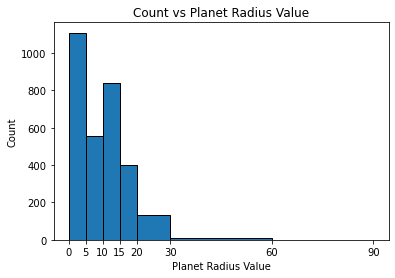

In [11]:
xmax = df_TOI_cleaned['Planet Radius Value'].max()
print(xmax)
bins = [0,5,10,15,20,30,60,90]
plt.hist(df_TOI_cleaned['Planet Radius Value'].values, bins=bins,edgecolor='k')
plt.xticks(bins)
plt.xlabel('Planet Radius Value')
plt.ylabel('Count')
plt.title('Count vs Planet Radius Value')
plt.show()

The histogram shows the exoplanet candidates' size is mostly around the lower end, between 1 to 5 Earth's radius. The majority of the size is under 20 Earth's radius. With only a few that got around and above 60. To put this into perspective, Jupiter, the larger planet in our solar system, has about 11 times Earth's radius in size. However, there are false positive candidates in there and their values can be faulty, so let's clean them out.


In [12]:
# In candidate disposition, KP stands for known planets and CP stands for confirmed planets, which means their data is reliable
# and accurate. Other dispositions like FA (false alarm), or FP (false positive) has faulty values that we need to clean out
df_TOI_actual = df_TOI_cleaned.loc[((df_TOI_cleaned['Disposition'] == 'KP') | (df_TOI_cleaned['Disposition'] == 'CP'))]
df_TOI_actual = df_TOI_actual.reset_index(drop=True)
print(df_TOI_actual.shape)
df_TOI_actual.head()

(329, 44)


,Disposition,Planet Transit Midpoint Value,Planet Transit Midpoint Upper Unc,Planet Transit Midpoint Lower Unc,Planet Transit Midpoint Limit Flag,Planet Orbital Period Value,Planet Orbital Period Upper Unc,Planet Orbital Period Lower Unc,Planet Orbital Period Limit Flag,Planet Transit Duration Value,...,Stellar Effective Temperature Limit Flag,Stellar log(g) Value,Stellar log(g) Upper Unc,Stellar log(g) Lower Unc,Stellar log(g) Limit Flag,Stellar Radius Value,Stellar Radius Upper Unc,Stellar Radius Lower Unc,Stellar Radius Limit Flag,TOI Created Date
0,KP,2.459364e+06,0.000699,-0.000699,0,2.180577,0.000118,-0.000118,0,2.905781,...,0,4.21017,1.964110,-1.964110,0,1.271460,0.063558,-0.063558,0,2019-07-15 19:20:04
1,CP,2.458665e+06,0.001819,-0.001819,0,15.507730,0.000110,-0.000110,0,5.049360,...,0,4.30881,0.268555,-0.268555,0,1.170920,0.054673,-0.054673,0,2019-08-16 20:20:48
2,CP,2.458661e+06,0.000839,-0.000839,0,17.471288,0.000068,-0.000068,0,4.297932,...,0,4.49925,0.019231,-0.019231,0,0.974669,0.054698,-0.054698,0,2019-08-16 20:20:47
3,KP,2.458656e+06,0.000152,-0.000152,0,2.977637,0.000002,-0.000002,0,3.124044,...,0,4.25824,0.298282,-0.298282,0,1.220260,0.064412,-0.064412,0,2019-08-16 20:20:41
4,CP,2.458654e+06,0.000388,-0.000388,0,0.518239,0.000005,-0.000005,0,0.749996,...,0,4.88693,0.098941,-0.098941,0,0.390989,0.011740,-0.011740,0,2019-08-16 20:20:48


23.720461899999997


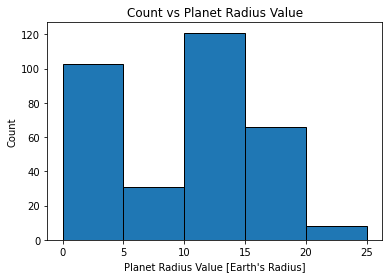

In [13]:
# Now we have the confirmed and known planets, let's make the histograph again 
xmax = df_TOI_actual['Planet Radius Value'].max()
print(xmax)
bins = [0,5,10,15,20,25]
plt.hist(df_TOI_actual['Planet Radius Value'].values, bins=bins,edgecolor='k')
plt.xticks(bins)
plt.xlabel("Planet Radius Value [Earth's Radius]")
plt.ylabel('Count')
plt.title('Count vs Planet Radius Value')
plt.show()

As we can see, the known planets are concentrated in the lower range, under 15 Earth's radius. The maximum not exceeding 25 Earth's radius. This give us a hint on how we can use this planet radius value to predict a planet candidate later.

Text(0, 0.5, 'TESS Magnitude')

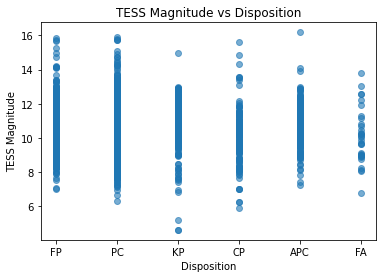

In [14]:
# Let's take a look at another column, TESS magnitude. Brightness of the host star as measured using the TESS-band in units of 
# magnitudes as reported in the TESS Input Catalog.
# We'll do a scatter plot to see the known/confirmed planets and candidates in other dispositions
plt.scatter(x=df_TOI_cleaned['Disposition'], y=df_TOI_cleaned['TESS Magnitude'],alpha=0.6)
plt.title('TESS Magnitude vs Disposition')
plt.xlabel("Disposition")
plt.ylabel("TESS Magnitude")

Since the scatter plot is a little cramped, even with the opacity for each point set to 0.6, so we can't see the distribution in each collection. It is more sensible to make it a violin plot so the characteristic is more visible.

<ipython-input-15-f91fc9465238>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','FP','PC','KP','CP','APC','FA'])


Text(0.5, 1.0, 'TESS Magnitude vs Disposition')

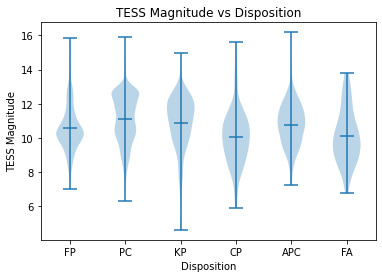

In [15]:
unq = df_TOI_cleaned.Disposition.unique()
n = unq.size
mag = np.zeros(shape=(n), dtype=object)

# creating a 2d array for the violin plot

# grouping by disposition and putting the data into an array
i = 0
while i < n:
    mag[i] = df_TOI_cleaned.loc[df_TOI_cleaned['Disposition']==unq[i],['TESS Magnitude']].to_numpy()
    i+=1

fig, ax = plt.subplots()
ax.violinplot(mag,range(len(unq)),showmeans=True)
ax.set_xticklabels(['','FP','PC','KP','CP','APC','FA'])
ax.set_xlabel("Disposition")
ax.set_ylabel("TESS Magnitude")
ax.set_title("TESS Magnitude vs Disposition")

Comparing to the scatter plot, we can directly see the distribution much better. For example, the PC disposition is basically a solid line in the scatter plot, now it is clear shown that the asymmetrical distribution around the mean, which is close to 11, and the range is from 6 to 16. We still cannot directly see an obvious correlation between the disposition and the TESS magnitude, but machine learning can help us later.

In astronomy, planets have their own region they need to clear out or accumulate the material from. The further out a planet is from the host star, the larger that region is. Let's assume that the density of the material is about the same (in reality we have to differentiate inside and outside the frostline, and the host star's property will change distance of the frostline, etc). According to Kepler's Third Law, the squares of the orbital periods of the planets are directly proportional to the cubes of the semi-major axes of their orbits. Will the plot of planet orbital period vs planet radius value show a positive correlation? Let's find out

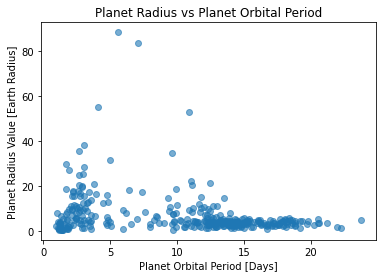

In [16]:
plt.scatter(x=df_TOI_actual['Planet Radius Value'],y=df_TOI_actual['Planet Orbital Period Value'],alpha = 0.6)
plt.title('Planet Radius vs Planet Orbital Period')
plt.xlabel('Planet Orbital Period [Days]')
plt.ylabel('Planet Radius Value [Earth Radius]')
plt.show()

The plot does not show obvious correlation between the two variables. However, the nature of the detection method (TESS) might explain this phenomenon. TESS is using trasit method to detect exoplanet, it means that it detects the difference in brightness of the host star when a planet pass in front of it[1]. That means, this method can only detect planets whose orbit and host star is directly edge on to us. The further the planet gets from its host star, the smaller the chance that orbit is edge on. Therefore, transit method prefer larger planets that are close to the host star - greater dip in brightness and shorter period to detect and confirm. That is the reason the orbital period doesn't even reach 1 year, which is the Earth's orbital period.
Additionally, we see that there are exoplanets that are very large and close to the host star. Those are called "hot jupiter", the type of exoplanet that transit method prefers. 


[1] More detailed explaination can be found here: https://www.nasa.gov/content/about-tess
[2] Hot Jupiter https://exoplanets.nasa.gov/resources/1040/hot-jupiter/

<img src="http://www.nasa.gov/sites/default/files/styles/full_width/public/thumbnails/image/tessbeautypass.jpg">

# Machine learning


The goal is to fit and train a model so that it can be used for later exoplanet candidates with the same features. To classify the candidate, I am going to use K-nearestneighbor classifier from Sklearn. 

In [17]:
# cleaned up the column that is irrelevant to our machine learning
df_TOI_cleaned = df_TOI_cleaned.drop(columns=['TOI Created Date'])
# change the diposition column into numeric value which the classifier can use 
df_TOI_cleaned['Label'] = [1 if x == 'KP' or x == 'CP' else 0 for x in df_TOI_cleaned['Disposition']] 
df_TOI_cleaned = df_TOI_cleaned.drop(columns=['Disposition'])
print(df_TOI_cleaned.shape)
df_TOI_cleaned.head()

(3048, 43)


,Planet Transit Midpoint Value,Planet Transit Midpoint Upper Unc,Planet Transit Midpoint Lower Unc,Planet Transit Midpoint Limit Flag,Planet Orbital Period Value,Planet Orbital Period Upper Unc,Planet Orbital Period Lower Unc,Planet Orbital Period Limit Flag,Planet Transit Duration Value,Planet Transit Duration Upper Unc,...,Stellar Effective Temperature Limit Flag,Stellar log(g) Value,Stellar log(g) Upper Unc,Stellar log(g) Lower Unc,Stellar log(g) Limit Flag,Stellar Radius Value,Stellar Radius Upper Unc,Stellar Radius Lower Unc,Stellar Radius Limit Flag,Label
0,2.459230e+06,0.001657,-0.001657,0,2.171348,0.000264,-0.000264,0,2.017220,0.319588,...,0,4.19,0.07,-0.07,0,2.169860,0.072573,-0.072573,0,0
1,2.459250e+06,0.001925,-0.001925,0,1.931671,0.000008,-0.000008,0,3.180000,0.173000,...,0,4.03,0.09,-0.09,0,2.010000,0.090000,-0.090000,0,0
2,2.459230e+06,0.002365,-0.002365,0,3.577575,0.000669,-0.000669,0,2.934708,0.343917,...,0,4.14,0.07,-0.07,0,2.150400,0.060467,-0.060467,0,0
3,2.459248e+06,0.001300,-0.001300,0,6.998921,0.000014,-0.000014,0,3.953000,0.437000,...,0,3.71,0.09,-0.09,0,2.700000,0.130000,-0.130000,0,0
4,2.459231e+06,0.003123,-0.003123,0,2.469696,0.000579,-0.000579,0,2.324444,0.426817,...,0,4.46,0.09,-0.09,0,0.941335,0.054613,-0.054613,0,0


So let's do a simple K-NN classifier from Sklearn. We have around 3000 entries to make the test test and train set, we are splitting the test and train dataset 20/80. 

In [18]:
features = df_TOI_cleaned
target = df_TOI_cleaned.Label
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1, test_size=.20)

Using a single for-loop, we can see that what 'n' value works the best for our K-NN model.

In [19]:
for i in range(1,21,2):
    knn = KNeighborsClassifier(n_neighbors=i)

    # Fitting Model to the train set
    knn.fit(X_train, y_train)

    # Predicting on the test set
    y_pred = knn.predict(X_test)
    print(i,metrics.accuracy_score(y_test, y_pred))

1 0.8311475409836065
3 0.860655737704918
5 0.8704918032786885
7 0.8819672131147541
9 0.8786885245901639
11 0.8754098360655738
13 0.8754098360655738
15 0.8737704918032787
17 0.8770491803278688
19 0.8786885245901639


From the above result, we can see that different k values does produce slightly different accuracy scores. In our case, 7 works the best since it has the highest accuracy score, so let's use 7 for our final K-NN model.

In [20]:
# Final K-NN Classifier model
knn = KNeighborsClassifier(n_neighbors=7)

# Fitting Model to the train set
knn.fit(X_train, y_train)

# Predicting on the test set
y_pred = knn.predict(X_test)


We can also use a different method classier.I will use random forest for our next model, and k fold cross validation technique that Sklearn provides. Since our dataset is not that large, I think 5 fold is more than sufficient.  

In [48]:
k = 5

kf = KFold(n_splits=k, random_state=None)
acc_score = []
forest = RandomForestClassifier()
for train_index , test_index in kf.split(features):
    X_train , X_test = features.iloc[train_index,:],features.iloc[test_index,:]
    y_train , y_test = target[train_index] , target[test_index]
    
    forest.fit(X_train,y_train)
    pred_values = forest.predict(X_test)
    
    acc = metrics.accuracy_score(pred_values , y_test)
    acc_score.append(acc)
    print(confusion_matrix(y_test,pred_values))
avg_acc_score = sum(acc_score)/k
print(avg_acc_score)

[[512   0]
 [  0  98]]
[[513   0]
 [  0  97]]
[[586   0]
 [  0  24]]
[[594   0]
 [  0  15]]
[[513   1]
 [  0  95]]
0.999671592775041


By the look of our average accuracy score, our random forest did surprisingly well. Maybe a little too well. I have no idea if I have done something wrong or this model and data just fit like that (I think it's the previous one). If the random forest model is really that good, I should use the random forest classifier instead of the K-NN classifier. 